In [1]:
import sklearn.metrics
import numpy as np
import pandas as pd
from transparentai.datasets import load_adult, load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from transparentai.models import classification
from transparentai import fairness

In [2]:
data = load_adult()
X, Y = data.drop(columns='income'), data['income']
X = X.select_dtypes('number')
Y = Y.replace({'>50K':1, '<=50K':0})
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.33, random_state=42)
clf = RandomForestClassifier()
clf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [3]:
y_true = Y_train
y_true_valid = Y_valid
y_pred = clf.predict_proba(X_train)
y_pred_valid = clf.predict_proba(X_valid)

In [4]:
privileged_group = {
    'gender':['Male'],                
    'age': lambda x: x > 30 & x < 55, 
#     'workclass': ['Private'],
#     'marital-status': lambda x: 'Married' in x,
#     'race':['White']
}

df_valid = data.loc[X_valid.index,:]
df_train = data.loc[X_train.index,:]

res_train = fairness.model_bias(y_true, 
                                y_pred, 
                                df_train,
                                privileged_group)

res_valid = fairness.model_bias(y_true_valid, 
                                y_pred_valid, 
                                df_valid,
                                privileged_group)

In [5]:
print(res_train['age'])
print()
print(res_valid['age'])

{'statistical_parity_difference': -0.15374968621878998, 'disparate_impact': 0.14882552008733574, 'equal_opportunity_difference': -0.27918264749635013, 'average_odds_difference': -0.13959132374817507}

{'statistical_parity_difference': -0.09868134173375277, 'disparate_impact': 0.12144926999388804, 'equal_opportunity_difference': -0.16608457038039662, 'average_odds_difference': -0.09485175201404339}


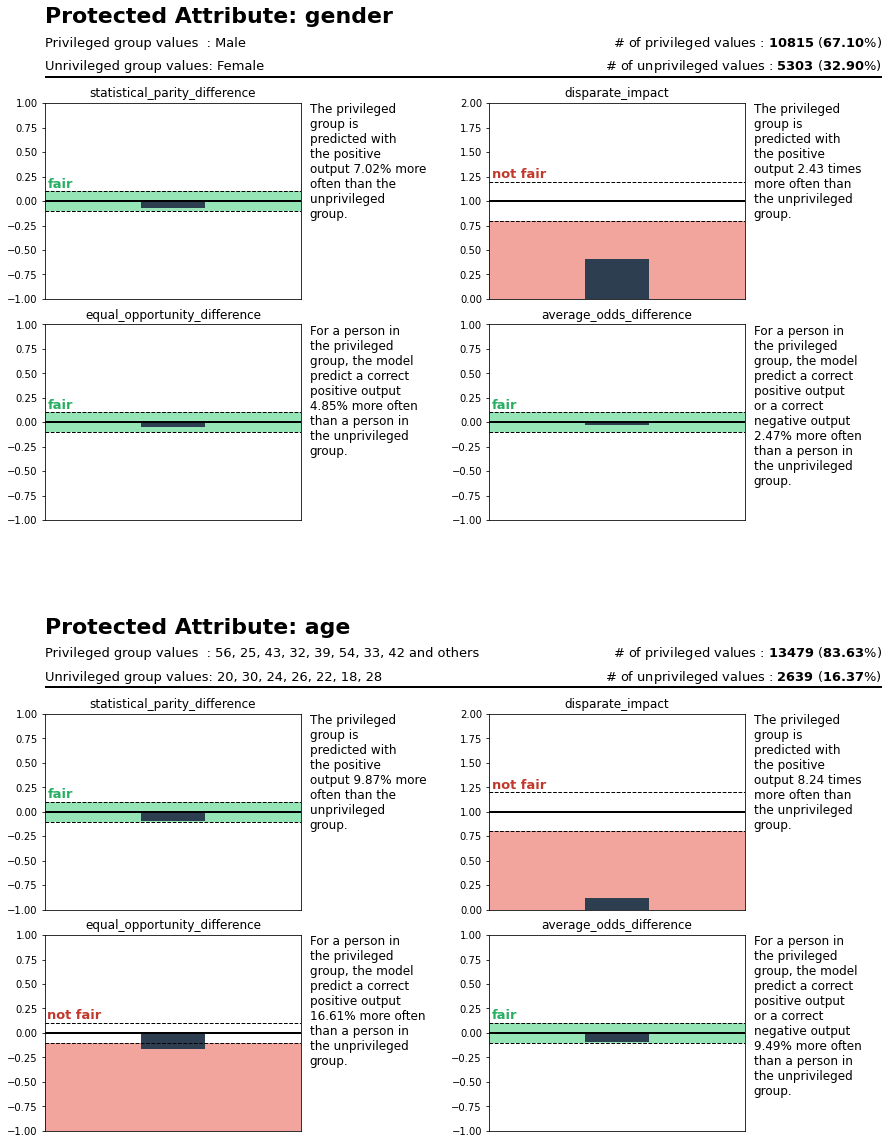

In [6]:
fairness.plot_bias(y_true_valid, y_pred_valid, df_valid, privileged_group)

In [7]:
from transparentai.datasets import load_boston
from sklearn.linear_model import LinearRegression

data = load_boston()
X, Y = data.drop(columns='MEDV'), data['MEDV']
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.33, random_state=42)
regr = LinearRegression()
regr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [8]:
y_true = Y_train
y_true_valid = Y_valid
y_pred = regr.predict(X_train)
y_pred_valid = regr.predict(X_valid)

In [9]:
privileged_group = {
    'AGE': lambda x: (x > 30) & (x < 55)
}

df_valid = data.loc[X_valid.index,:]
df_train = data.loc[X_train.index,:]

res_train = fairness.model_bias(y_true, y_pred, df_train,
                                privileged_group, regr_split='mean')

res_valid = fairness.model_bias(y_true_valid, y_pred_valid, 
                                df_valid, privileged_group, regr_split='mean')

In [10]:
print(res_train['AGE'])
print()
print(res_valid['AGE'])

{'statistical_parity_difference': -0.24278409090909092, 'disparate_impact': 0.6386469344608879, 'equal_opportunity_difference': 0.030268418046830448, 'average_odds_difference': -0.13176501578278632}

{'statistical_parity_difference': -0.32598939208486327, 'disparate_impact': 0.5575858250276855, 'equal_opportunity_difference': 0.05590062111801242, 'average_odds_difference': -0.19990227625885348}


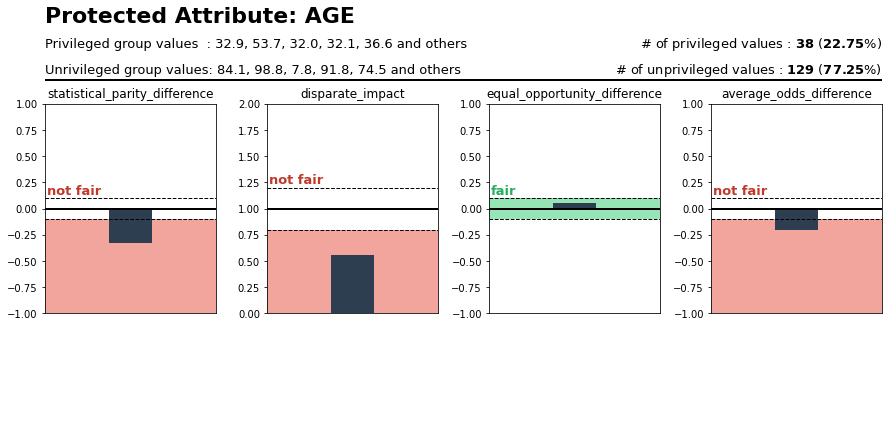

In [11]:
fairness.plot_bias(y_true_valid, y_pred_valid, 
                   df_valid, privileged_group, 
                   regr_split='mean', with_text=False)

In [13]:
data = load_adult()

In [14]:
data = load_adult()

privileged_group = {
    'gender':['Male'],                
    'marital-status': lambda x: 'Married' in x,
    'race':['White']
}

fairness.find_correlated_feature(data, privileged_group, corr_threshold=0.4)

{'gender': {'marital-status': 0.4593,
  'occupation': 0.4239,
  'relationship': 0.6465},
 'marital-status': {'relationship': 0.4881,
  'gender': 0.4593,
  'income': 0.4482},
 'race': {'native-country': 0.4006}}